In [1]:
!pip install imageio
!pip install torch
!pip install kaggle 
!pip install pywidgets

  Could not find a version that satisfies the requirement pywidgets (from versions: )
No matching distribution found for pywidgets


In [0]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch 
from torch.utils import data

In [12]:
#upload the kaggle.json
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"vpanuragpandey00","key":"1d184b263612a1c0442f6cba1dfc455c"}'}

In [14]:
#checks the file
ls -1ha kaggle.json

kaggle.json


In [0]:
#make a directory and copy the file to that directory 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the file permission 
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
#download the dataset
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 49.1MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 80.3MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 59.8MB/s]
 97% 158M/163M [00:02<00:00, 55.1MB/s]
100% 163M/163M [00:02<00:00, 60.5MB/s]
 87% 33.0M/37.9M [00:00<00:00, 20.9MB/s]
100% 37.9M/37.9M [00:00<00:00, 48.7MB/s]


In [18]:
!ls
!unzip train.zip

 depths.csv	    kaggle.json		    test.zip
'kaggle (1).json'   sample_data		    train.csv
'kaggle (2).json'   sample_submission.csv   train.zip
Archive:  train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png  

In [0]:
#we define a class to process and extract the data
'''
A major part of this is to distinguish between the images and mask, good to learn it as we go

'''
class TSGData(data.Dataset):
  
  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, index):
    file_id = self.file_list[index]
    #image folder and path 
    image_folder = os.path.join(self.root_path,'images')
    image_path = os.path.join(image_folder,file_id + '.png')
    #mask 
    mask_folder = os.path.join(self.root_path,'masks')
    mask_path = os.path.join(mask_folder,file_id + '.png')
    
    #read it 
    image = np.array(imageio.imread(image_path), dtype = np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype = np.uint8)
    
    return image,mask
    


In [0]:
train_mask = pd.read_csv('train.csv')
depth = pd.read_csv('depths.csv')

train_path = './'

file_list = list(train_mask['id'].values)
dataset = TSGData(train_path,file_list)


def plot2x2array(image, mask):
  #invoke matplotlib
  f, ax = plt.subplots(1,2)
  ax[0].imshow(image)
  ax[1].imshow(mask)
  ax[0].grid()
  ax[1].grid()
  ax[0].set_title('image')
  ax[1].set_title('mask')
  

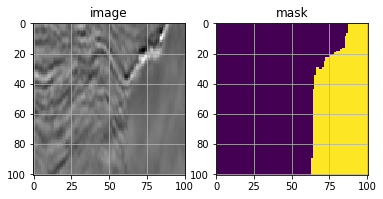

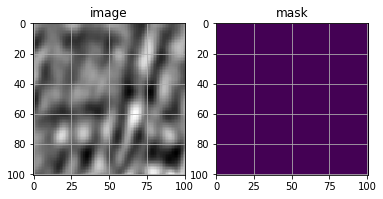

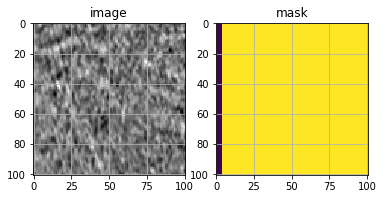

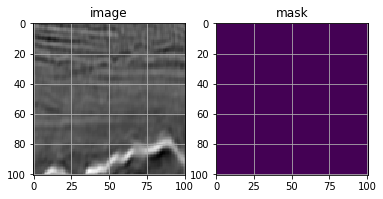

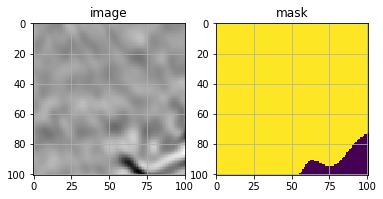

In [39]:
for i in range(5):
  image, mask = dataset[np.random.randint(0, len(dataset))]
  plot2x2array(image, mask)

Text(0.5, 1.0, 'Depth Distr')

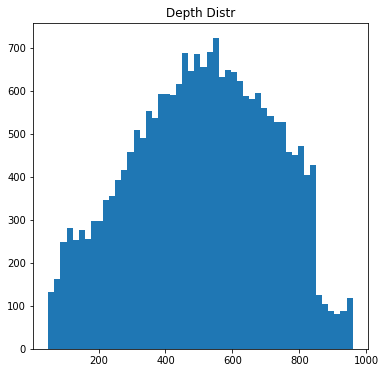

In [40]:
plt.figure(figsize= (6,6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth Distr')

In [0]:
def convertMask(rleString, height, width):
  rows, cols = height, width
  try:
    rleNumbers = [int(numString) for numString in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols, dtype = uint8)
    for index,length in rlePairs:
      index-=1
      img[index:index+length] = 255
      
    img = img.reshape(cols,rows)
    img = img.T
   
  except:
    img = np.zeros((cols,rows))
  
  return img
      

In [0]:
def salt_prop(imgArray):
  try:
    unique, counts = np.unique(imgArray, return_counts = True)
    return counts[1]/10201
  except:
    return 0.0

In [0]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: convertMask(x, 101, 101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_prop(x))

In [50]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,843
1,a266a2a9df,5051 5151,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,797


Text(0.5, 1.0, 'Propotion of Salt vs depth')

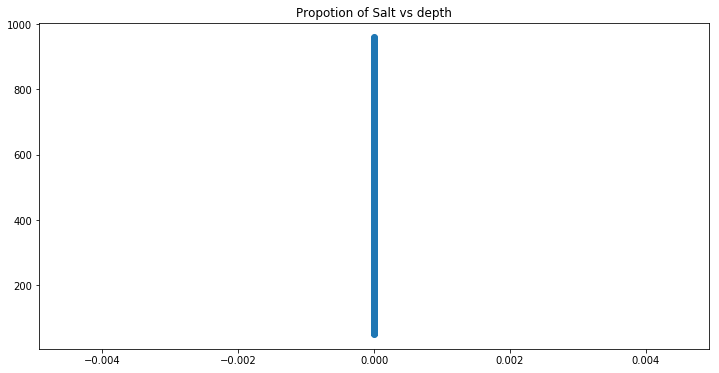

In [51]:
plt.figure(figsize = (12,6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Propotion of Salt vs depth')

In [0]:
#Unet finally 
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [0]:
im_height = 128
im_width = 128
border = 5
im_chan = 2
n_features = 1

In [59]:
input_img = Input((im_height,im_width,im_chan), name='img')
input_features = Input((n_features,), name='feat')

c1 = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(input_img)
c1 = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(p1)
c2 = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(p2)
c3 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(p3)
c4 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(c4)
p4 = MaxPooling2D((2,2))(c4)

f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8,8, n_features))(f_repeat)
p4_feat = concatenate([p4,f_conv], -1)

c5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(p4_feat)
c5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(c5)

u6 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c5)
#skip connection 
u6 = concatenate([u6,c4])
c6 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(u6)
c6 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(c6)

u7 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(u7)
c7 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(c7)

u8 = Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = concatenate([u8,c2])
c8 = Conv2D(16, (2,2), activation = 'relu', padding = 'same')(u8)
c8 = Conv2D(16, (2,2), activation = 'relu', padding = 'same')(c8)

u9 = Conv2DTranspose(8, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = concatenate([u9,c1], axis=3)
c9 = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(u9)
c9 = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(c9)

outputs = Conv2D(1, (1,1), activation = 'sigmoid')(c9)

model = Model(inputs = [input_img, input_features], outputs = [outputs])
model.compile(optimizer='adam', loss = 'binary_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 8)  584         conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 

In [60]:
!pip install ipywidgets

In [63]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize

train_ids = next(os.walk(train_path+"images"))[2]


X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype = np.float32)
y = np.zeros((len(train_ids),im_height, im_width, 1), dtype = np.float32)

X_feat = np.zeros((len(train_ids), n_features), dtype = np.float32)

print('Getting and resizing the images')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = train_path
  img = load_img(path + '/images/' + id_, grayscale=True)
  x_img = img_to_array(img)
  x_img = resize(x_img, (128,128,1), mode = 'constant', preserve_range = True)
  
  x_center_mean = x_img[border:-border, border:-border].mean()
  x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
  x_csum -= x_csum[border:-border, border:-border].mean()
  x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())
  
  mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
  mask = resize(mask, (128,128,1), mode = 'constant', preserve_range = True)
  
  X[n, ...,0] = x_img.squeeze() / 255
  X[n, ...,1] = x_csum.squeeze()
  y[n] = mask/255
  
print('Done!')
  

Getting and resizing the images


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 4000/4000 [00:22<00:00, 179.44it/s]

Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [66]:
callbacks = [
    EarlyStopping(patience = 5, verbose = 1),
    ReduceLROnPlateau(patience = 3, verbose = 1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose = 1, save_best_only = True, save_weights_only = True)
]

results = model.fit({
    'img':X_train,
    'feat':X_feat_train},
    y_train,
    batch_size = 16,
    epochs = 50,
    callbacks = callbacks,
    validation_data = ({
        'img':X_valid,
        'feat':X_feat_valid},
    y_valid)
)

Instructions for updating:
Use tf.cast instead.
Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 23s 7ms/step - loss: 0.5563 - val_loss: 0.5213

Epoch 00001: val_loss improved from inf to 0.52135, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.4565 - val_loss: 0.3969

Epoch 00002: val_loss improved from 0.52135 to 0.39689, saving model to model-tgs-salt-1.h5
Epoch 3/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.3671 - val_loss: 0.3194

Epoch 00003: val_loss improved from 0.39689 to 0.31944, saving model to model-tgs-salt-1.h5
Epoch 4/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.2987 - val_loss: 0.2958

Epoch 00004: val_loss improved from 0.31944 to 0.29585, saving model to model-tgs-salt-1.h5
Epoch 5/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.2577 - val_loss: 0.2543

Epoch 00005: val_loss